In [10]:
import pickle
import pandas as pd
from tqdm import tqdm
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [11]:
# read datasets

# CRISPR/RNAi
ge_matrix = pickle.load(open('../general_datasets/ge_matrix.pkl', 'rb'))

# CRISPR和RNAi分别的所有gene
genes_all_key = {}
genes_all_key['CRISPR'] = list(ge_matrix['CRISPR'].columns)
genes_all_key['RNAi'] = list(ge_matrix['RNAi'].columns)

# ge_cut
ge_cut = {}
ge_cut['CRISPR'] = -0.237
ge_cut['RNAi'] = -0.325

seeds = [0,42,100,1000,10000,100000,1000000,10000000,100000000,1000000000]

ft_posi_seed_key = pickle.load(open('PCorr_PPI_datasets/ft_posi_seed_key.pkl', 'rb'))
ft_nega_seed_key = pickle.load(open('PCorr_PPI_datasets/ft_nega_seed_key.pkl', 'rb'))

cl_lst = ['MCF7','HCT116','K562','HL60','A375']

In [ ]:
# reported PPIs
data = pd.read_excel('PCorr_PPI_datasets/aan0346__Tables_S19_to_S27.xlsx',sheet_name='Table S27',skiprows=3)
data = data[(data['Gene A'].isna()==False)&(data['Gene B'].isna()==False)]

ppis_reported = set()
for i in data.index:
    g1 = data.loc[i,'Gene A']
    g2 = data.loc[i,'Gene B']
    ppi = [g1,g2]
    if len(set(ppi)) == 2:
        ppi_ = sorted(ppi)
        ppis_reported.add((ppi_[0],ppi_[1]))

# Extraction of feature matrices
ft_reported_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    genes_all = genes_all_key[ge_key]
    ppis_list = []
    ft_all_list = []
    for ppi in tqdm(ppis_reported):
        ppi_lst = sorted(list(ppi))
        g1 = ppi_lst[0]
        g2 = ppi_lst[1]
        
        if g1 in genes_all and g2 in genes_all:
            ge_1 = ge_matrix_dict[ge_key][g1].dropna()
            ge_2 = ge_matrix_dict[ge_key][g2].dropna()

            ge_f_1 = ge_1[ge_1 < ge_cut[ge_key]]
            ge_f_2 = ge_2[ge_2 < ge_cut[ge_key]]

            ccls_inter = list(set(ge_f_1.index) & set(ge_f_2.index))
            ge_final_1 = ge_f_1[ccls_inter]
            ge_final_2 = ge_f_2[ccls_inter]

            if len(ccls_inter) >= 10:
                # pearson相关性系数
                pearson_r = pearsonr(ge_final_1, ge_final_2)

                pearson_coeff = pearson_r[0]
                pearson_p = pearson_r[1]

                # ols模型
                X_with_intercept = sm.add_constant(ge_final_1)
                model_ols = sm.OLS(ge_final_2, X_with_intercept)
                ols_r = model_ols.fit()

                ols_coeff_0 = ols_r.params[0]
                ols_se_0 = ols_r.bse[0]

                ols_coeff_1 = ols_r.params[1]
                ols_se_1 = ols_r.bse[1]

                g1_essen = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_final_1]))
                g2_essen = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_final_2]))

                g1_mean = np.mean(ge_final_1)
                g2_mean = np.mean(ge_final_2)
                g1_std = np.std(ge_final_1)
                g2_std = np.std(ge_final_2)

                g1_min = min(ge_final_1)
                g1_25 = np.percentile(ge_final_1, 25)
                g1_50 = np.percentile(ge_final_1, 50)
                g1_75 = np.percentile(ge_final_1, 75)
                g1_max = max(ge_final_1)

                g2_min = min(ge_final_2)
                g2_25 = np.percentile(ge_final_2, 25)
                g2_50 = np.percentile(ge_final_2, 50)
                g2_75 = np.percentile(ge_final_2, 75)
                g2_max = max(ge_final_2)

                ge_e_1 = []
                for k in ge_1:
                    if k > 0:
                        ge_e_1.append(0)
                    else:
                        ge_e_1.append(k)

                ge_e_2 = []
                for k in ge_2:
                    if k > 0:
                        ge_e_2.append(0)
                    else:
                        ge_e_2.append(k)

                g1_essen_all = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_e_1]))
                g2_essen_all = math.sqrt(
                    np.sum([np.power((i - 0), 2) for i in ge_e_2]))

                g1_mean_all = np.mean(ge_e_1)
                g2_mean_all = np.mean(ge_e_2)
                g1_std_all = np.std(ge_e_1)
                g2_std_all = np.std(ge_e_2)

                g1_min_all = min(ge_e_1)
                g1_25_all = np.percentile(ge_e_1, 25)
                g1_50_all = np.percentile(ge_e_1, 50)
                g1_75_all = np.percentile(ge_e_1, 75)
                g1_max_all = max(ge_e_1)

                g2_min_all = min(ge_e_2)
                g2_25_all = np.percentile(ge_e_2, 25)
                g2_50_all = np.percentile(ge_e_2, 50)
                g2_75_all = np.percentile(ge_e_2, 75)
                g2_max_all = max(ge_e_2)

                features = [len(ccls_inter), pearson_coeff, pearson_p,
                            ols_coeff_0, ols_se_0,
                            ols_coeff_1, ols_se_1,
                            g1_essen, g2_essen,
                            g1_essen_all, g2_essen_all,
                            g1_mean, g2_mean, g1_std, g2_std,
                            g1_25, g1_50, g1_75, g2_25, g2_50, g2_75,
                            g1_min, g2_min, g1_max, g2_max,
                            g1_mean_all, g2_mean_all, g1_std_all, g2_std_all,
                            g1_25_all, g1_50_all, g1_75_all, g2_25_all, g2_50_all, g2_75_all,
                            g1_min_all, g2_min_all, g1_max_all, g2_max_all,
                            ]
                ppis_list.append(ppi)
                ft_all_list.append(features)

    ft_reported_key[ge_key] = pd.DataFrame(ft_all_list, index=ppis_list,
                                           columns=['SCCLs_number', 'pearson_coeff', 'pearson_p',
                                                    'ols_coeff_0', 'ols_se_0',
                                                    'ols_coeff_1', 'ols_se_1',
                                                    'g1_essen', 'g2_essen',
                                                    'g1_essen_all', 'g2_essen_all',
                                                    'g1_mean', 'g2_mean', 'g1_std', 'g2_std',
                                                    'g1_25', 'g1_50', 'g1_75', 'g2_25', 'g2_50', 'g2_75',
                                                    'g1_min', 'g2_min', 'g1_max', 'g2_max',
                                                    'g1_mean_all', 'g2_mean_all', 'g1_std_all', 'g2_std_all',
                                                    'g1_25_all', 'g1_50_all', 'g1_75_all', 'g2_25_all', 'g2_50_all',
                                                    'g2_75_all',
                                                    'g1_min_all', 'g2_min_all', 'g1_max_all', 'g2_max_all',
                                                    ])

# PCorr-PPI scores of reported PPIs
r_reported_key = {}
for ge_key in ['CRISPR', 'RNAi']:
    ft = ft_reported_key[ge_key]
    X_data = np.array(ft, dtype='float32')

    if ge_key == 'CRISPR':
        rf = RandomForestClassifier(random_state=42,
                                    n_estimators=300, max_features='sqrt', max_depth=15,
                                    min_samples_split=9, min_samples_leaf=4)
    else:
        rf = RandomForestClassifier(random_state=42,
                                    n_estimators=300, max_features='sqrt', max_depth=15,
                                    min_samples_split=8, min_samples_leaf=3)

    ft_posi_seed = ft_posi_seed_key[ge_key]
    ft_nega_seed = ft_nega_seed_key[ge_key]

    for s in tqdm(seeds):
        ft_posi = ft_posi_seed[s]
        ft_posi['label'] = [1] * len(ft_posi)
        ft_nega = ft_nega_seed[s]
        ft_nega['label'] = [0] * len(ft_nega)

        ft_seed = pd.concat([ft_posi, ft_nega], axis=0)

        X = np.array(ft_seed.iloc[:, :-1], dtype='float32')
        y = np.array(ft_seed.iloc[:, [-1]], dtype='float32')
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

        rf.fit(X_train, y_train)
        
        y_probs = rf.predict_proba(X_data)[:, 1]
        ft['y_probs_{}'.format(s)] = y_probs

    ft['y_probs'] = np.mean(ft[['y_probs_{}'.format(s) for s in seeds]], axis=1)
    r_reported_key[ge_key] = ft

In [3]:
def asign_multi_series_to_df(series_list, col_list):
    df = pd.DataFrame()
    max_len = max([len(i) for i in series_list])

    for i in tqdm(range(len(series_list))):
        series_ = series_list[i]
        if len(series_) < max_len:
            series_ = list(series_)
            series_.extend([np.nan] * (max_len - len(series_)))
            df[col_list[i]] = series_
        else:
            df[col_list[i]] = series_
    return df

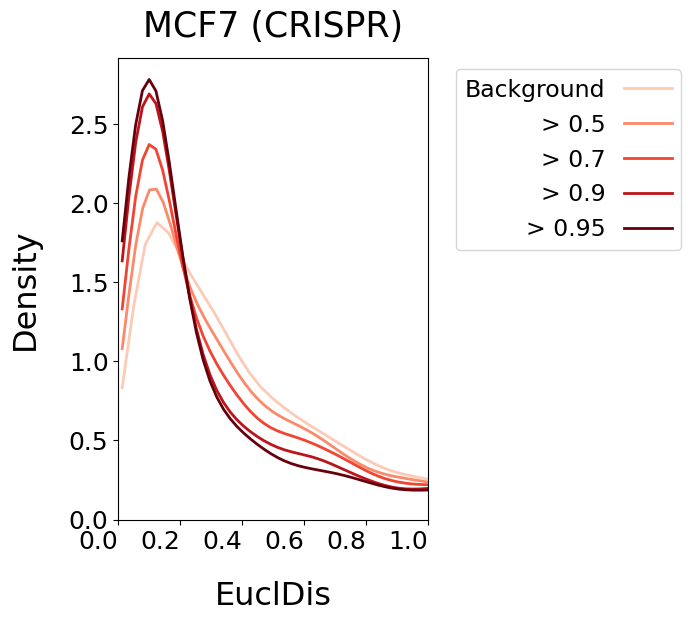

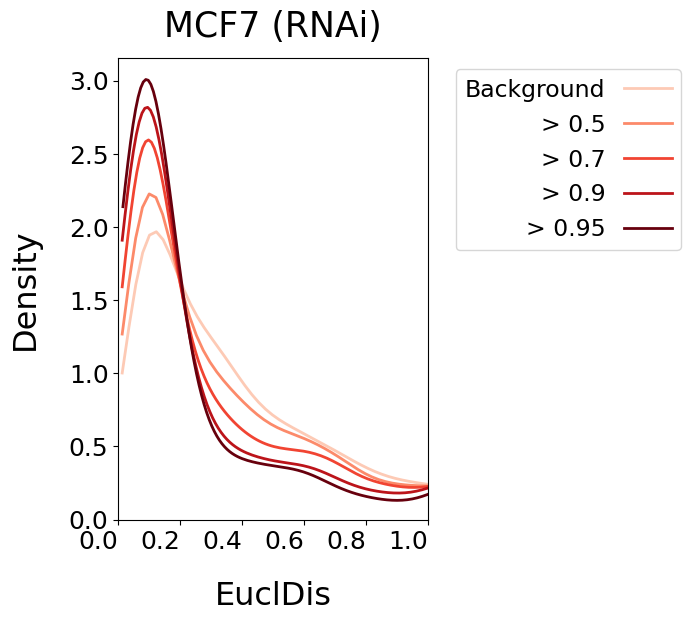

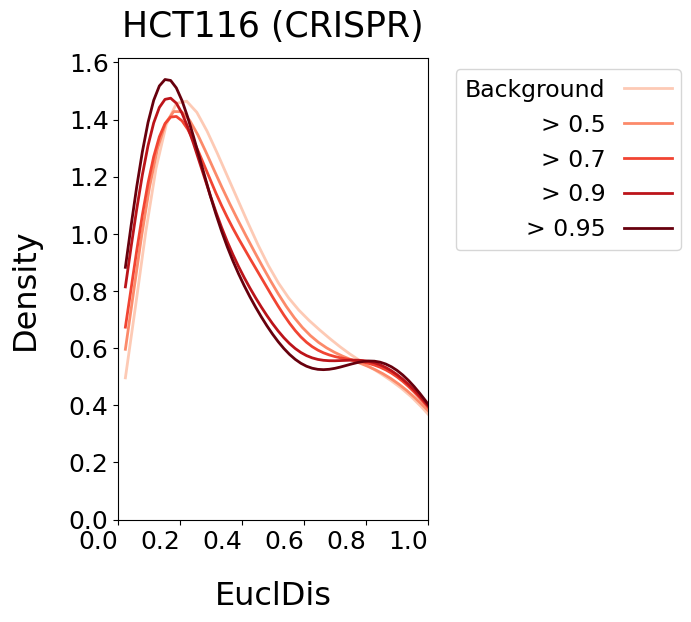

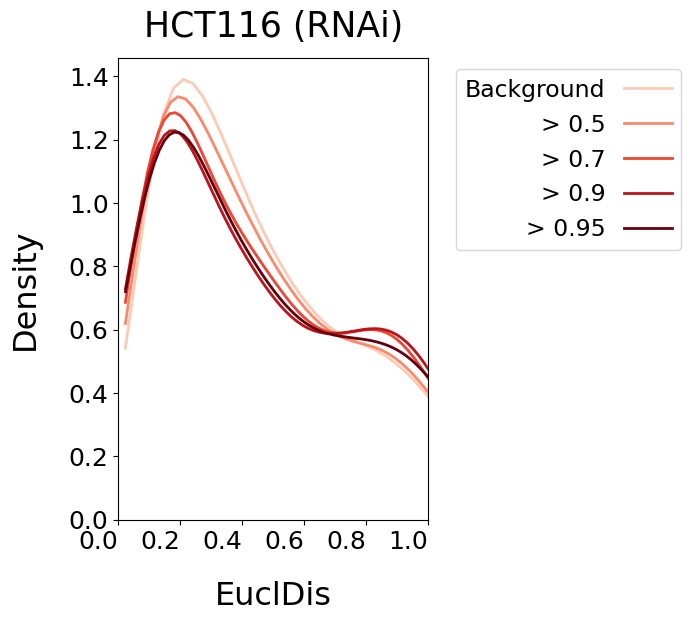

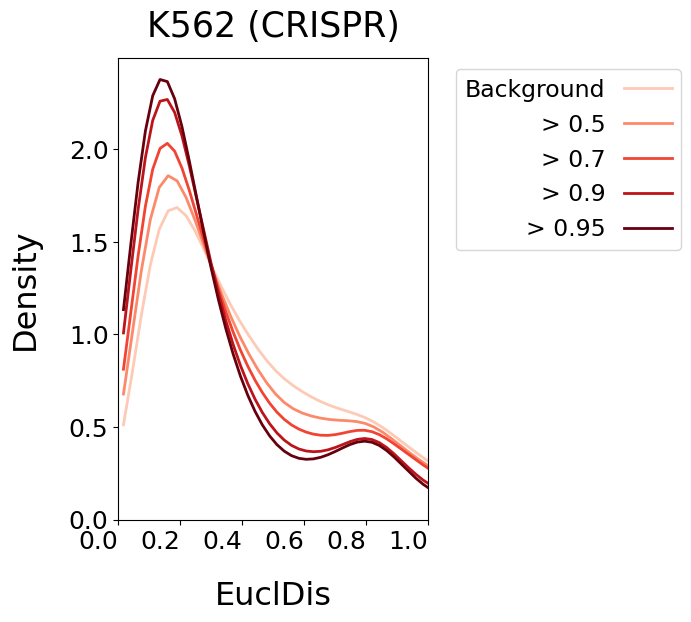

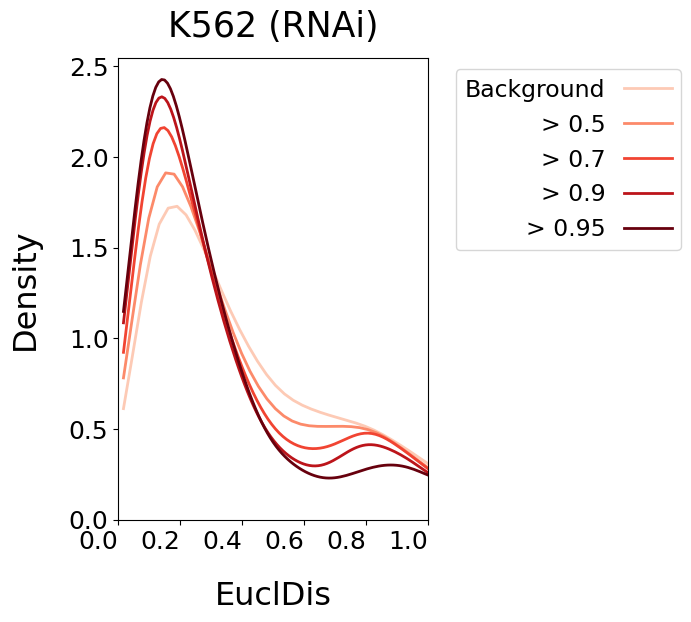

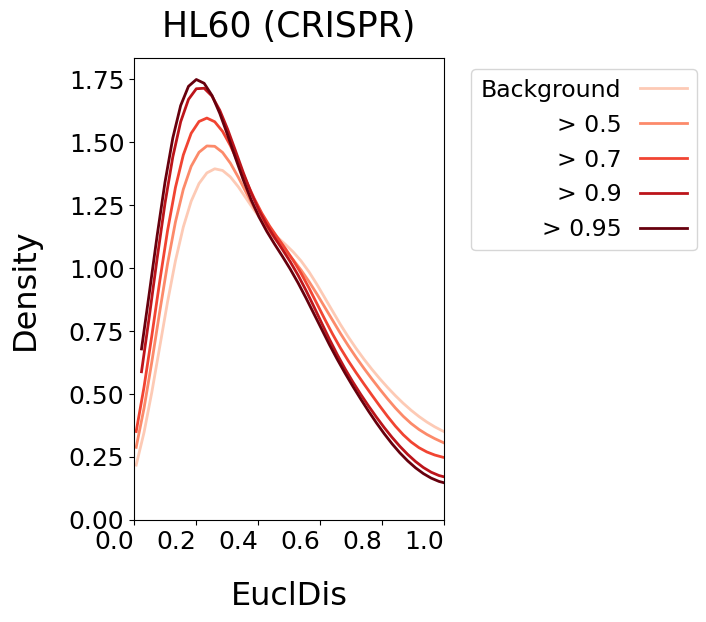

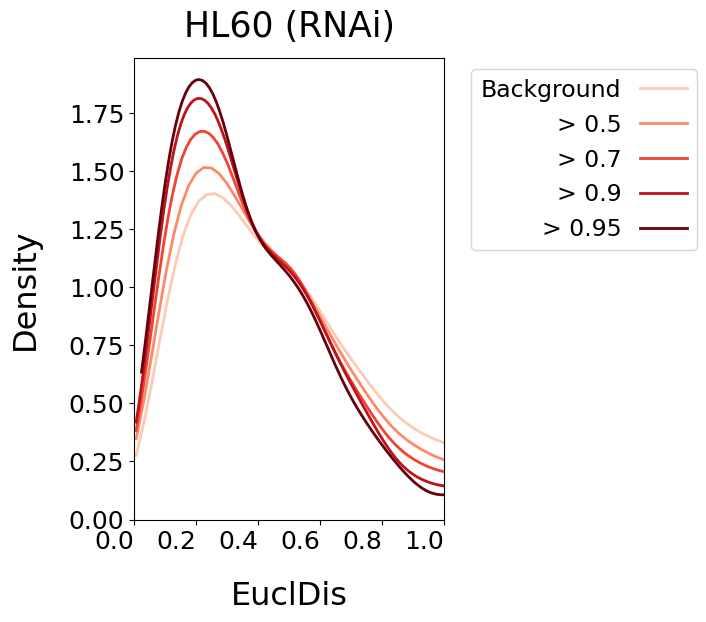

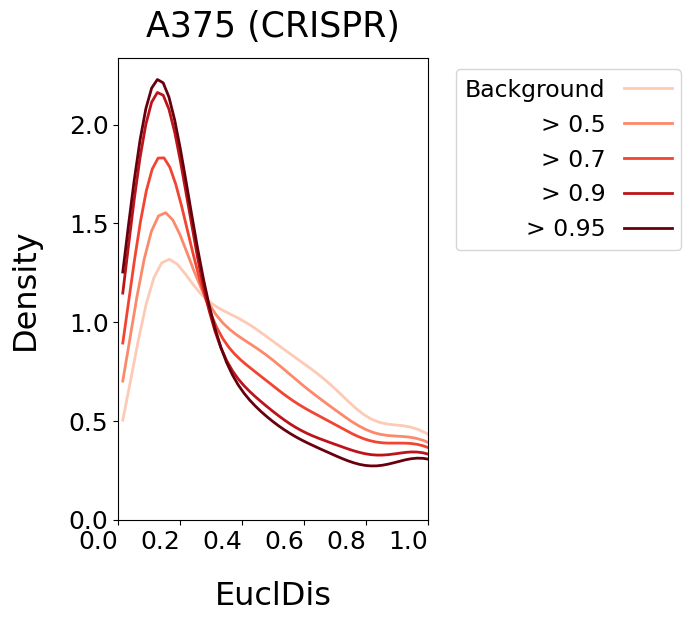

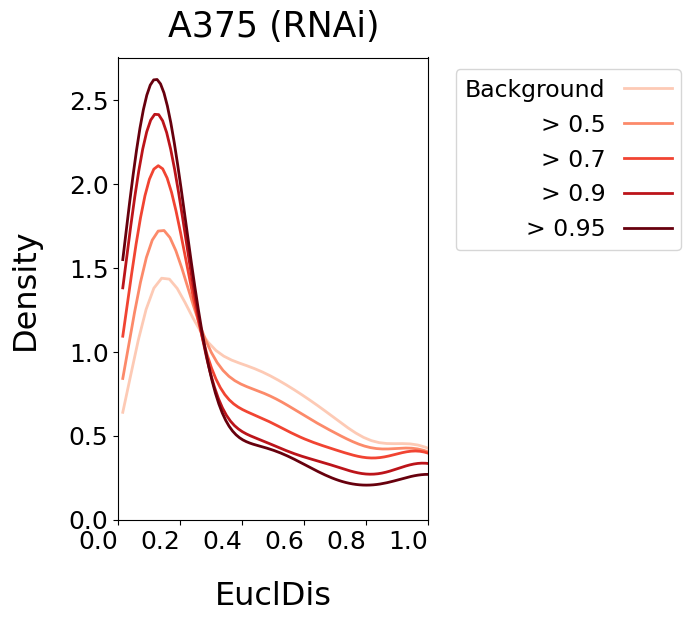

In [12]:
# comparing TPCA-derived EuclDis values
r_reported_key = pickle.load(open('PCorr_PPI_datasets/r_reported_key.pkl', 'rb'))

data = pd.read_excel('PCorr_PPI_datasets/aan0346__Tables_S19_to_S27.xlsx',sheet_name='Table S27',skiprows=3)
data = data[(data['Gene A'].isna()==False)&(data['Gene B'].isna()==False)]
data = data[data['Publication Num'] > 1]

data_idx = []
for i in data.index:
    g1 = str(data.loc[i,'Gene A'])
    g2 = str(data.loc[i,'Gene B'])
    ppi = sorted([g1,g2])
    data_idx.append((ppi[0],ppi[1]))
data.index = data_idx

scores_cut = [0,0.5,0.7,0.9,0.95]

cmap = get_cmap("Reds")
colors = [cmap(i) for i in np.linspace(0.2, 1, len(scores_cut))]

for cl in cl_lst:
    for ge_key in r_reported_key.keys():
        r = r_reported_key[ge_key]
        plt.figure(figsize=(4, 6))
        n = -1
        for cut in scores_cut:
            n = n + 1
            r_sig = r[r['y_probs'] > cut]
            if cut == 0:
                label_txt = 'Background'
            else:
                label_txt = '> {}'.format(cut)
            ppi_lst = list(set(data.index)&set(r_sig.index))
            s = data['{}_ElucDis'.format(cl)][ppi_lst]
            sns.kdeplot(s, cut=0, fill=False, color=colors[n],
                        alpha=1, linewidth=2, label=label_txt)

        plt.yticks(ha='right', fontsize=18)
        plt.xticks(ha='right', fontsize=18, rotation=0)
        plt.xlabel('EuclDis', fontsize=23,labelpad=20)
        plt.ylabel('Density', fontsize=23, labelpad=20)
        plt.xlim(0,1)
        plt.title('{} ({})'.format(cl,ge_key), fontsize=25, pad=15)
        plt.legend(loc=2, bbox_to_anchor=(1.05,1.0),fontsize=17,markerfirst=False,
                   markerscale=1,scatterpoints=1,ncol=1,title_fontsize=17)
        plt.show()